# Forest Fires Dataset Analysis and Model Evaluation

This notebook performs regression analysis on the Forest Fires dataset. The objectives are:
1. Preprocess the data and perform feature engineering.
2. Use 5-Fold Cross Validation with Linear Regression, Lasso, Ridge, and ElasticNet.
3. Use `cross_val_predict` and `cross_val_score` for additional evaluations.
4. Evaluate and compare results from different models and methods.
5. Re-evaluate models using a simplified feature set based on insights gained from Lasso, Ridge, and ElasticNet.



## Import Libraries and Load Dataset

We start by importing the necessary libraries and loading the Forest Fires dataset.

In [452]:
import pandas as pd
import numpy as np
from summarytools import dfSummary
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import root_mean_squared_error


### Step 1: Load and Inspect the Dataset

We will start by loading the Forest Fires dataset and inspecting its structure.


In [453]:
# Load the dataset
df = pd.read_csv('../data/forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Step 2: Data Quality Checks

In [454]:
dfSummary(df, is_collapsible=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,X[int64],1. 42. 63. 24. 85. 76. 37. 18. 59. 9,91 (17.6%)86 (16.6%)73 (14.1%)61 (11.8%)60 (11.6%)55 (10.6%)48 (9.3%)30 (5.8%)13 (2.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADdklEQVR4nO3cQWrbUABF0e9iSjuxCYEsJovoYrsI7yaEaNCETtxBR2lDI9vSbcDnbOBncPlGQi+b4/E4oPDpf/8BXA+xkREbGbGRERsZsZERG5nNGOPrGONzdN7P4/H4HJ3FB7O9vb39ttvtborDpml63Gw23wV3nba73e7m/v7+eb/fv6x50NPT05fD4XDz8PDweYwhtiu0HWOM/X7/cnd39yM472twBh+UBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy2zF+f/6z9kHFGXxs22maHg+Hw80IPv+ZpulxjPFz7XP4mHwWTmbjf31QKW82t9qVywYvxi4kgxdjF8ZoBy/GLlfOS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyyeDF2IUxwsGLsQs+Cydj8ELGAwKZNX9G/WzyymrrKmsq/rTKusqairesua6ypuIVDwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkVllXWVPxltXWVdZU/Mln4WSsq8gsebO5yfinxQYvBi68Z5HBi4ELcyw5eDFw4Z+81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOzyODFwIU5Fhu8GLjwHp+FkzF4IeNmI2PwQsbghYzBCxkvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjI2CGSsq8gscbO50Zjl4nWVVRVzXbSusqriFEusq6yqmMVLXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIXDV4MXTjFxYMXQxfm8lk4GYMXMpfcbG40TnL24MXQhVOdNXgxdOEclwxeDF04iZe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5qx1lVUV5zh7XWVVxalsEMhYV5GZe7O5xbjYrHWVJRVLeHddZUnFUuauqyypuJiXumTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTeHbwYt7CUWYMX4xaW4LNwMgYvZN662dxirOKvwYtxC2t5NXgxbmFNbw1ejFtYhZe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5tW6ypKKNf21rrKkYi02CGSsq8h4QCAjNjJiIyM2MmIjIzYyvwByI+Pzz4T1fAAAAABJRU5ErkJggg=="">",0(0.0%)
2,Y[int64],1. 42. 53. 64. 35. 26. 97. 8,203 (39.3%)125 (24.2%)74 (14.3%)64 (12.4%)44 (8.5%)6 (1.2%)1 (0.2%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADFklEQVR4nO3dTWrbYBiF0VfGpPVExgSyhHbmBWQRXWwX4QVk2D0EEw3qNBN30FDakB8srCthnbOCr/Ag9Qu6SXM8HgsSFmMfgPkQGzFiI0ZsxIiNmKaqVlV1NfZBwp6Ox+Nh7EPMzfL6+vpb27absQ+S1HXdvmma74LLWrZtu7m9vT2s1+vHsQ+T8PDw8Hm3223u7++vqkpsQcuqqvV6/Xhzc/Nz7MMErcY+wBy5IBAjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMcuqP5/djH2QlDn9W6dm2XXdfrfbbWpGn910XbevqqexzzE3PgsnprGIJ2WqTzZPngs0ycGLQcplmtzgxSDlck118DKbm/Gc+KEuMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmImt66a0lk4r0muq6yfLpMNAjHWVcQM+WTzdOI/g62rLKR4aZB1lYUUrxlyXTWZ2y3T4Ie6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMIIMXoxVeM9jgxWiFl3wWTozBCzEuCMSc+zXq1cmbzrqusqjiPWdbV1lU8ZFzr6ssqniTCwIxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEXO2dZVFFR8567rKoor3+CycGOsqYvo+2TzBOFmvwYthC32cPHgxbKGvvoMXwxZO5oe6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMyYMXwxb66jV4MWyhD5+FE2PwQowLAjH/vka9GhnU33WVxRRDW7Rtu9lut/U85xvi745CVT3/n221Wv0a+yBcPhcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNmUVV1OBw+jX0QLt+i67r93d2dxRSD81k4MdZVxLggELNomuZr0zR+pQKDW1TVl6pyG2VwXqPEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlFVP6rKL3BmcAYvxHiNEiM2YsRGjNiIERsxvwEbOznqgzhTaAAAAABJRU5ErkJggg=="">",0(0.0%)
3,month[object],1. aug2. sep3. mar4. jul5. feb6. jun7. oct8. apr9. dec10. jan11. other,184 (35.6%)172 (33.3%)54 (10.4%)32 (6.2%)20 (3.9%)17 (3.3%)15 (2.9%)9 (1.7%)9 (1.7%)2 (0.4%)3 (0.6%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAENElEQVR4nO3dwWobVwCG0SsjQrORMAI/jB8iD9uH0NsYYy3qkI26sNPWtRxkpPmkTs/ZZTeGj+vMcP9ksd/vBxRuLv0A/H+IjYzYyIiNjNjIiI2M2MiIjYzYyCzGGF/HGF8u/SAT+bHf758v/RC8WG42m2+r1er20g8yhd1u97hYLH4X3HVYrlar2/v7++f1ev390g9zTk9PT79tt9vbh4eHL2MMsV2B5RhjrNfr73d3d39c+mEm8PXSD8DfvCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ5Rgvd78u/SDnNsef6b9uudvtHrfb7e2Y4d2v3W73OMb4cenn4IUNApmFfzKLyhxPNqfZlZrdusqi6nrNal1lUXXd5riumt1b9Vz4qEtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZmVoOXufwcczW7wYuRy/VyLZyMwQuZc5xsThKOcvLgxcCEY500eDEw4TPOMXiZxVss0/NRl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcxJgxcDEz7j5MGLg

The following can be established from the data:
- There are no missing records.
- The columns are in their right data type format.
- We have 4 duplicate values. We will have to investigate further.
- The shape of the data is 517 by 13.

In [455]:
# Investigate duplicated records
duplicated_data = df[df.duplicated()]
duplicated_data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
53,4,3,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00
100,3,4,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00
215,4,4,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66
303,3,6,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00


We recognized that there are only partial duplicates in the records and this will not affect our analysis hence the records won't be removed.

### Step 3: Exploring the data

In [456]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 11 numerical features : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

We have 2 categorical features : ['month', 'day']


In [457]:
# proportion of count data on categorical columns
for col in categorical_features:
    print(df[col].value_counts(normalize=True) * 100)
    print('---------------------------')

month
aug    35.589942
sep    33.268859
mar    10.444874
jul     6.189555
feb     3.868472
jun     3.288201
oct     2.901354
apr     1.740812
dec     1.740812
jan     0.386847
may     0.386847
nov     0.193424
Name: proportion, dtype: float64
---------------------------
day
sun    18.375242
fri    16.441006
sat    16.247582
mon    14.313346
tue    12.379110
thu    11.798839
wed    10.444874
Name: proportion, dtype: float64
---------------------------


Univariate Analysis
1. Numerical features

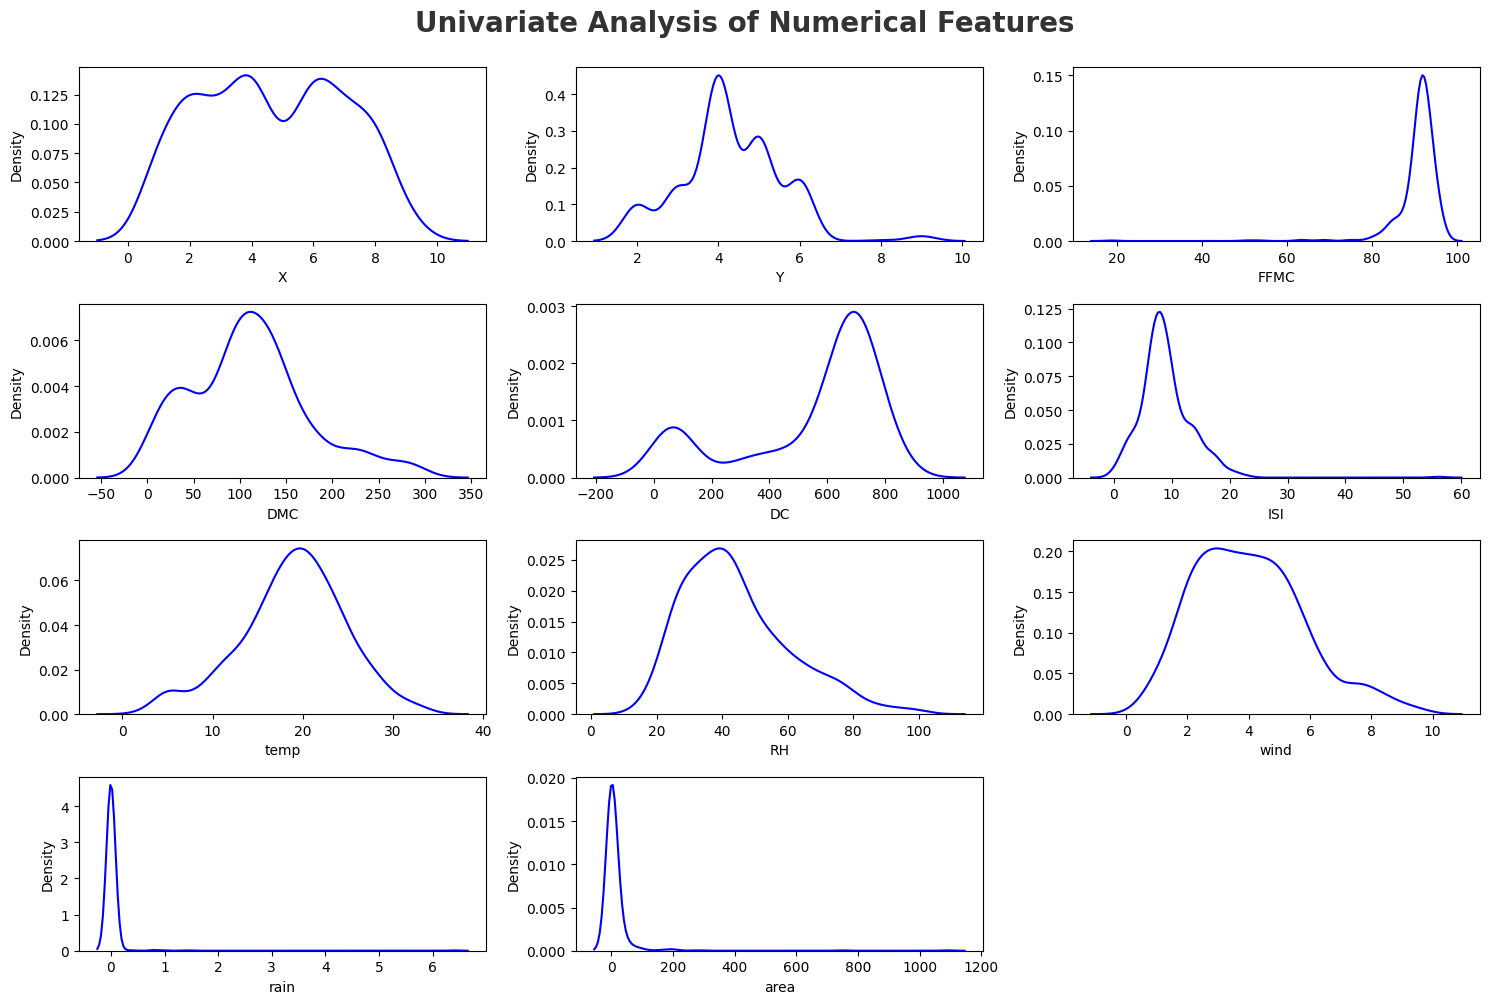

In [458]:
plt.figure(figsize=(15, 10))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(x=df[numeric_features[i]], color='blue')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

Insights
- Rain, Area and ISI columns are right skewed.
- FFMC and DC columns are left skewed.
- The rest of the columns are normally distributed.

2. Categorical features

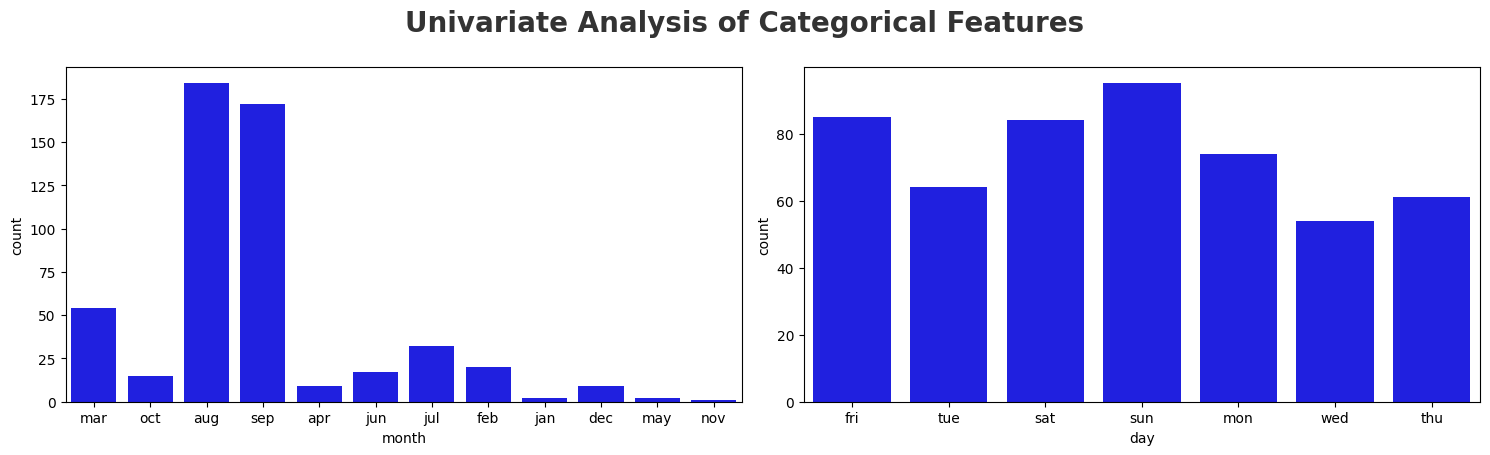

In [459]:
# categorical columns
plt.figure(figsize=(15, 8))
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(categorical_features)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=df[categorical_features[i]], color='blue')
    plt.xlabel(categorical_features[i])
    plt.tight_layout()

Insights
- Aug and Sep have values exceeding 150.
- Jan, May and Nov have extremely low counts in the dataset.
- The days of the week in the day column are uniformly distributed.

Mulitivariate Analysis
- Correlation Analysis

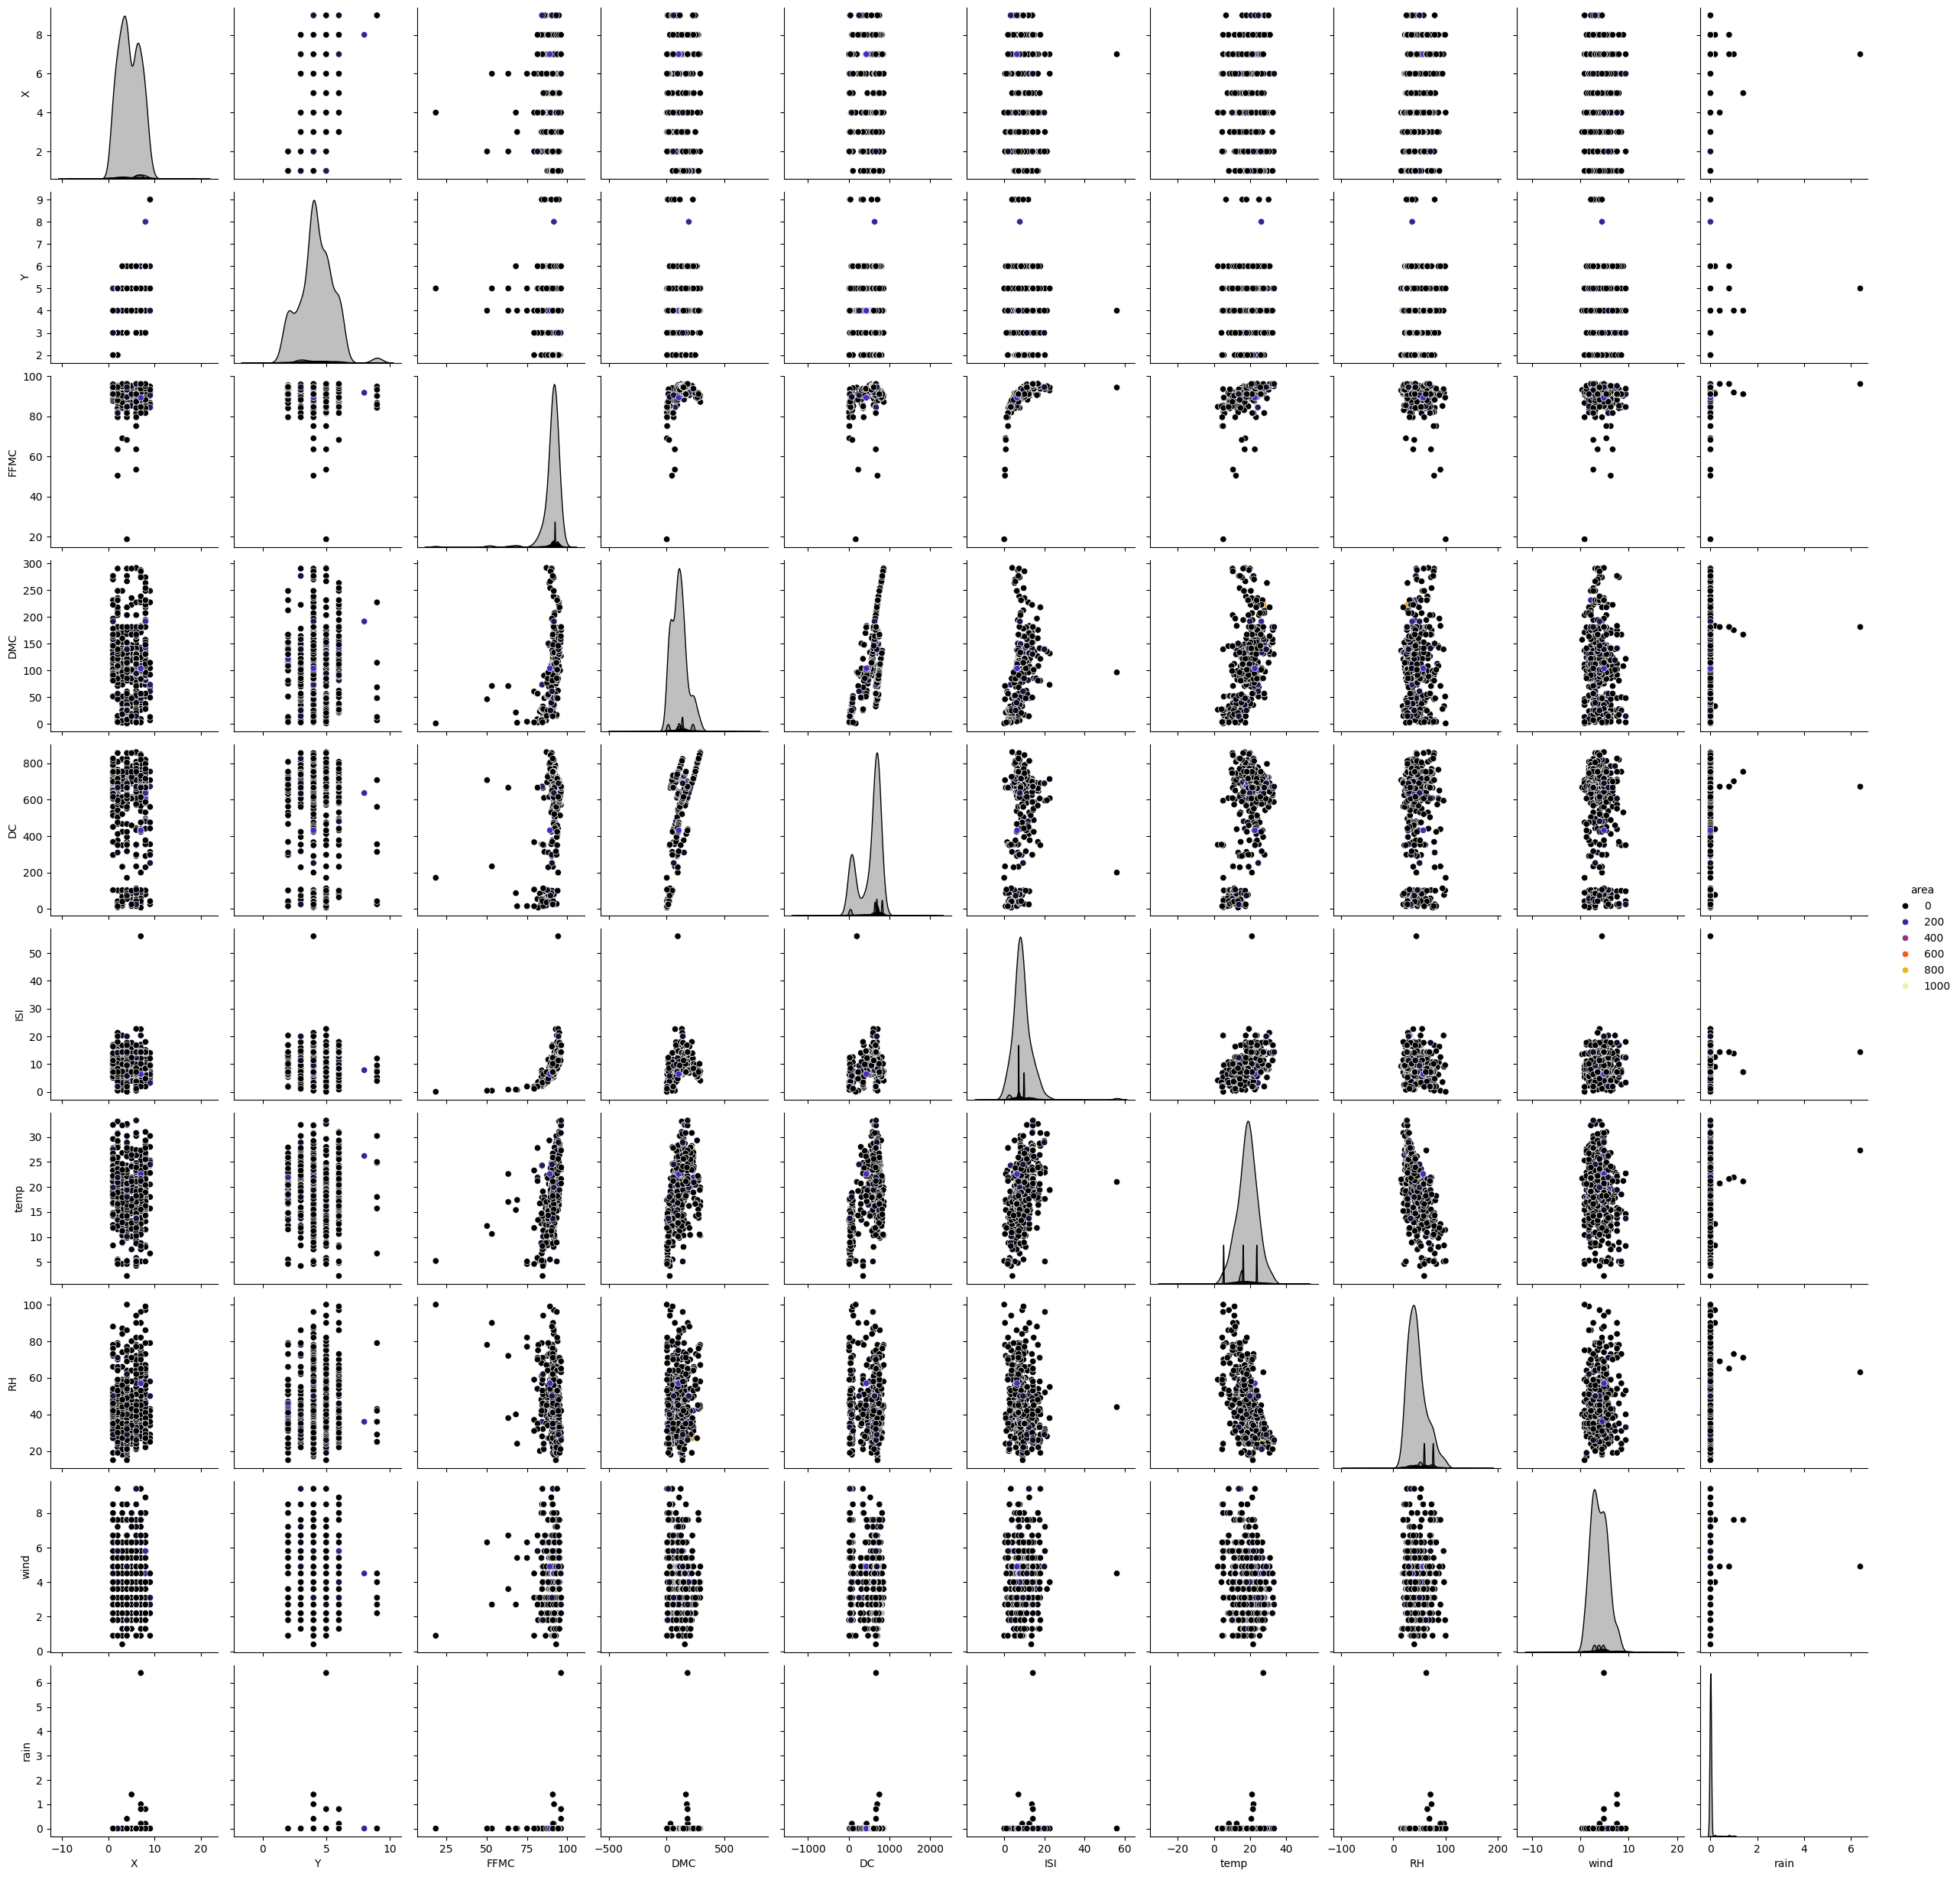

In [460]:
pairplot = sns.pairplot(df, hue="area", palette="CMRmap")

### Step 4: Split X and Y

In [461]:
# Split data to dependent and independent variable.
X = df.drop('area', axis=1)
y = df['area']

### Step 5: Feature Encoding

In [462]:
# Separate categorical and numerical features
num_features = list(X.select_dtypes(exclude="object").columns)
cat_features = list(X.select_dtypes(include="object").columns)

print(f"Numerical features are: {num_features}")
print(f"Categorical features are: {cat_features}")

Numerical features are: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
Categorical features are: ['month', 'day']


### Step 6: Create 4 different scalers for processing

In [463]:
#get the rain column and apply 'yeo-johnson' transformation
transform_columns = ['rain']

# Define different scalers to be used
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler()
}

### Step 7: Define models

In [464]:
models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}


### Step 8: Create preprocessing pipeline

In [465]:
# Function to create pipeline for a given scaler
def create_pipeline(scaler_name, scaler):
    numeric_transformer = scaler
    oh_transformer = OneHotEncoder()

    # PowerTransformer for specific columns
    transform_pipe = Pipeline(steps=[
        ('transformer', PowerTransformer(method='yeo-johnson'))
    ])

    # ColumnTransformer
    preprocessor = ColumnTransformer(
        [
            ("OneHotEncoder", oh_transformer, cat_features),
            ("Transformer", transform_pipe, transform_columns),
            (scaler_name, numeric_transformer, num_features)
        ]
    )

    # Create final pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    
    return pipeline

### Step 9: Perform cross validation (kfold, cross_val_predict, cross_val_score)

In [466]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over each scaler and model
for scaler_name, scaler in scalers.items():
    print(f"\nUsing Scaler: {scaler_name}")
    print("=================================")
    
    # Create and fit-transform the pipeline
    pipeline = create_pipeline(scaler_name, scaler)
    X_transformed = pipeline.fit_transform(X)
    
    for model_name, model in models.items():
        print(f"\nModel: {model_name}")
    
        
        # Perform 5-fold Cross-Validation using KFold and calculate RMSE
        rmse_scores = []
        
        for train_index, test_index in kf.split(X_transformed):
            X_train, X_test = X_transformed[train_index], X_transformed[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            rmse = root_mean_squared_error(y_test, y_pred)
            rmse_scores.append(rmse)
        
        print(f"KFold CV RMSE: {np.mean(rmse_scores):.4f}")
        
        # Repeat with cross_val_predict
        y_pred_cv = cross_val_predict(model, X_transformed, y, cv=kf)
        rmse_cv_predict = root_mean_squared_error(y, y_pred_cv)
        
        print(f"Cross-Val Predict RMSE: {rmse_cv_predict:.4f}")
        
        # Repeat with cross_val_score for RMSE, using 'neg_root_mean_squared_error'
        rmse_cv_score = cross_val_score(model, X_transformed, y, cv=kf, scoring='neg_root_mean_squared_error')
        print(f"Cross-Val Score RMSE: {abs(rmse_cv_score.mean()):.4f}")


Using Scaler: StandardScaler

Model: Linear
KFold CV RMSE: 3124000746346.6519
Cross-Val Predict RMSE: 6971953374945.4512
Cross-Val Score RMSE: 3124000746346.6519

Model: Lasso
KFold CV RMSE: 54.1499
Cross-Val Predict RMSE: 63.5856
Cross-Val Score RMSE: 54.1499

Model: Ridge
KFold CV RMSE: 55.2991
Cross-Val Predict RMSE: 64.0444
Cross-Val Score RMSE: 55.2991

Model: ElasticNet
KFold CV RMSE: 53.8443
Cross-Val Predict RMSE: 63.4248
Cross-Val Score RMSE: 53.8443

Using Scaler: MinMaxScaler

Model: Linear
KFold CV RMSE: 12918993979936.3789
Cross-Val Predict RMSE: 28831818873841.6523
Cross-Val Score RMSE: 12918993979936.3789

Model: Lasso
KFold CV RMSE: 54.0513
Cross-Val Predict RMSE: 63.7437
Cross-Val Score RMSE: 54.0513

Model: Ridge
KFold CV RMSE: 55.1262
Cross-Val Predict RMSE: 63.9978
Cross-Val Score RMSE: 55.1262

Model: ElasticNet
KFold CV RMSE: 53.9424
Cross-Val Predict RMSE: 63.6723
Cross-Val Score RMSE: 53.9424

Using Scaler: RobustScaler

Model: Linear
KFold CV RMSE: 28366963880

Predicted Vs Actual Area Comparison

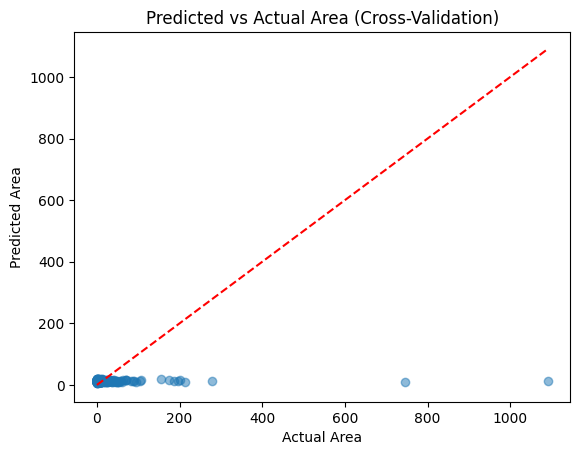

In [467]:
plt.figure()
plt.scatter(y, y_pred_cv, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.title('Predicted vs Actual Area (Cross-Validation)')
plt.show()

# Hyperparameter Tuning

In [468]:
# Define parameter grids for each model
param_grids = {
    'Lasso': {
        'alpha': np.logspace(-4, 4, 10)  
    },
    'Ridge': {
        'alpha': np.logspace(-4, 4, 10)
    },
    'ElasticNet': {
        'alpha': np.logspace(-4, 4, 10), 
        'l1_ratio': np.linspace(0, 1, 10)  
    }
}

# Define models without additional parameters
models = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}

# Define scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

# Dictionary to store best models and scores
best_models = {}
best_scores = {}

# Loop through each scaler
for scaler_name, scaler in scalers.items():
    print(f"\nUsing Scaler: {scaler_name}")
    
    # Transform the data using the current scaler
    X_scaled = pipeline.fit_transform(X)
    
    # Loop through each model and perform GridSearchCV for hyperparameter tuning
    for model_name, model in models.items():
        if model_name in param_grids:
            print(f"\nTuning hyperparameters for {model_name} with {scaler_name}...")
            
            # Set up GridSearchCV with the model and its parameter grid
            grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=kf, scoring='neg_root_mean_squared_error')
            
            # Fit grid search to the scaled data
            grid_search.fit(X_scaled, y)
            
            # Store the best estimator and best score
            best_models[(model_name, scaler_name)] = grid_search.best_estimator_
            best_scores[(model_name, scaler_name)] = abs(grid_search.best_score_)
            
            print(f"Best parameters for {model_name} with {scaler_name}: {grid_search.best_params_}")
            print(f"Best RMSE score for {model_name} with {scaler_name}: {abs(grid_search.best_score_):.4f}")


Using Scaler: StandardScaler

Tuning hyperparameters for Lasso with StandardScaler...
Best parameters for Lasso with StandardScaler: {'alpha': np.float64(2.782559402207126)}
Best RMSE score for Lasso with StandardScaler: 53.9923

Tuning hyperparameters for Ridge with StandardScaler...
Best parameters for Ridge with StandardScaler: {'alpha': np.float64(166.81005372000558)}
Best RMSE score for Ridge with StandardScaler: 53.9627

Tuning hyperparameters for ElasticNet with StandardScaler...
Best parameters for ElasticNet with StandardScaler: {'alpha': np.float64(2.782559402207126), 'l1_ratio': np.float64(0.0)}
Best RMSE score for ElasticNet with StandardScaler: 53.9614

Using Scaler: MinMaxScaler

Tuning hyperparameters for Lasso with MinMaxScaler...
Best parameters for Lasso with MinMaxScaler: {'alpha': np.float64(2.782559402207126)}
Best RMSE score for Lasso with MinMaxScaler: 53.9923

Tuning hyperparameters for Ridge with MinMaxScaler...
Best parameters for Ridge with MinMaxScaler: {'a